# Support Vector Machines challenge

In [13]:
# Imports
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [14]:
# Load the dataset
raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

# Exploratory Data Analysis and Feature Engineering

In [15]:
raw_data.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


So, we can see that the majority of columns are binary, either the recipe contains this ingredient are doesn't. We can also see that some of the columsn contain null values, let's see how many. 

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64


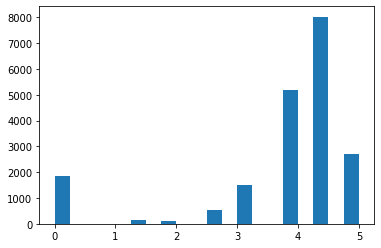

In [16]:
# find nulls
null_count = raw_data.isnull().sum()
print(null_count[null_count > 0])

# plot target variable
plt.hist(raw_data['rating'], bins=20)
plt.show()

We can drop the columns with null values. We can also see that our target varibale is not very equally distributed. 

In [17]:
raw_data_dropped = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)

Now, let's look at the top 30 most correlated varibales with the rating, these will be the features for our model. 

In [18]:
raw_data_dropped.corrwith(raw_data.rating).sort_values(ascending=False).head(30)

bon appétit        0.124549
peanut free        0.096087
soy free           0.092965
tree nut free      0.081347
bake               0.076978
roast              0.073499
fall               0.067343
sauté              0.066553
dinner             0.060957
kosher             0.059071
winter             0.055126
pescatarian        0.054034
thanksgiving       0.052990
onion              0.049997
grill/barbecue     0.048081
high fiber         0.047827
gourmet            0.047354
no sugar added     0.047197
tomato             0.046579
quick & easy       0.045216
herb               0.044253
pork               0.042463
beef               0.041550
cheese             0.041215
low carb           0.040738
mixer              0.040620
christmas          0.040595
sugar conscious    0.040573
braise             0.040155
low cal            0.038592
dtype: float64

We also need to turn this into a binary classification problem, so we need to create a new variable for our rating, for high and low ratings. 

In [19]:
def high_low_rate(x):
    if 0 < x <= 2.9:
        return 0
    return 1

raw_data_dropped['rating'] = raw_data['rating'].apply(high_low_rate)

raw_data_dropped.head()

,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,advance prep required,alabama,alaska,alcoholic,almond,...,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey,rating
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Text(0.5, 1.0, 'Categorized Ratings (0=low, 1=high)')

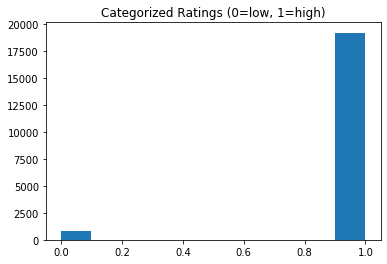

In [20]:
plt.hist(raw_data_dropped.rating)
plt.title('Categorized Ratings (0=low, 1=high)')

In [21]:
from sklearn.svm import SVR

keep_list = ['bon appétit', 'peanut free', 'soy free', 'tree nut free', 'bake', 'roast', 'fall', 'sauté', 'dinner',
            'kosher', 'winter', 'pescatarian', 'thanksgiving', 'onion', 'grill/barbecue', 'high fiber', 'gourmet', 
            'no sugar added', 'tomato', 'quick & easy', 'herb', 'pork', 'beef', 'cheese', 'low carb', 'mixer', 
            'christmas', 'sugar conscious', 'braise', 'low cal']

svr = SVR()
X = raw_data_dropped[keep_list].sample(frac=0.3, replace=True, random_state=1)
Y = raw_data.rating.sample(frac=0.3, replace=True, random_state=1)
svr.fit(X,Y)

C:\Users\keger\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [22]:
svr.score(X,Y)

-0.02369641419821944

In [23]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=5)

C:\Users\keger\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\keger\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\keger\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\keger\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

array([-0.02227987, -0.02254682, -0.03201484, -0.03423652, -0.04231716])

# Second Model

In [41]:
raw_data_dropped = raw_data.dropna()

raw_data_dropped['rating'] = raw_data['rating'].apply(high_low_rate)

C:\Users\keger\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
raw_data_dropped.corrwith(raw_data_dropped.rating).sort_values(ascending=False).head(31)

rating          1.000000
bon appétit     0.050268
roast           0.033111
thanksgiving    0.029530
sauté           0.026421
rosemary        0.025229
tomato          0.022986
goat cheese     0.022249
cilantro        0.021367
easter          0.021102
feta            0.021041
white wine      0.021013
mustard         0.019622
shrimp          0.019465
spring          0.019125
low carb        0.019121
fall            0.018884
chicken         0.018840
sour cream      0.016421
squash          0.016387
healthy         0.016385
cranberry       0.016291
almond          0.015968
turkey          0.015784
leafy green     0.015619
mango           0.015516
lime juice      0.015508
prune           0.015508
braise          0.015360
corn            0.015292
steak           0.015209
dtype: float64

In [42]:
keep_list = ['bon appétit', 'roast', 'thanksgiving', 'sauté', 'rosemary', 'tomato', 'goat cheese', 'cilantro', 
            'easter', 'feta', 'white wine', 'mustard', 'shrimp', 'spring', 'low carb', 'fall', 'chicken', 'sour cream', 
            'squash', 'healthy', 'cranberry', 'almond', 'turkey', 'leafy green', 'mango', 'lime juice', 'prune',
            'braise', 'corn', 'steak']

svr = SVR()
X = raw_data_dropped[keep_list].sample(frac=0.3, replace=True, random_state=1)
Y = raw_data_dropped.rating.sample(frac=0.3, replace=True, random_state=1)
svr.fit(X,Y)

C:\Users\keger\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [43]:
svr.score(X,Y)

-0.09039857898473458

In [44]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=5)

C:\Users\keger\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\keger\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\keger\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\keger\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

array([-0.16364491, -0.07802422, -0.0829512 , -0.15269513, -0.03699059])